In [110]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.neighbors import NearestNeighbors
from datetime import timedelta

In [111]:
data_inmet = pd.read_csv('../../model/additional_data/datasets/inmet_2019_2024.csv')
data_modis = pd.read_csv('../../model/data/modisTodos.csv')

In [112]:
# Verificar os tipos de dados das colunas de latitude e longitude
print("Tipos de dados em data_inmet:")
print(data_inmet.dtypes)
print("\nTipos de dados em data_modis:")
print(data_modis.dtypes)

Tipos de dados em data_inmet:
Data                                                      object
latitude                                                  object
longitude                                                 object
PRECIPITACAO TOTAL, HORARIO (mm)                         float64
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    float64
RADIACAO GLOBAL (KJ/m2)                                  float64
TEMPERATURA DO AR - BULBO SECO, HORARIA (0C)             float64
UMIDADE RELATIVA DO AR, HORARIA (%)                      float64
VENTO, RAJADA MAXIMA (m/s)                               float64
dtype: object

Tipos de dados em data_modis:
latitude      float64
longitude     float64
confidence    float64
dtype: object


In [113]:
# Verificar se há valores nulos
print("\nValores nulos em data_inmet:")
print(data_inmet[['latitude', 'longitude']].isnull().sum())
print("\nValores nulos em data_modis:")
print(data_modis[['latitude', 'longitude']].isnull().sum())


Valores nulos em data_inmet:
latitude     0
longitude    0
dtype: int64

Valores nulos em data_modis:
latitude     0
longitude    0
dtype: int64


In [114]:
# 2. Verificar os tipos e valores nulos
data_inmet['latitude'] = data_inmet['latitude'].astype(str).str.replace(',', '.').astype(float)
data_inmet['longitude'] = data_inmet['longitude'].astype(str).str.replace(',', '.').astype(float)

# Garantir o mesmo tipo para o MODIS
data_modis['latitude'] = data_modis['latitude'].astype(float)
data_modis['longitude'] = data_modis['longitude'].astype(float)

In [115]:
# Arredondar coordenadas para melhor combinar
data_inmet['latitude'] = data_inmet['latitude'].round(4)
data_inmet['longitude'] = data_inmet['longitude'].round(4)
data_modis['latitude'] = data_modis['latitude'].round(4)
data_modis['longitude'] = data_modis['longitude'].round(4)

In [116]:
# 3. Aplicar Nearest Neighbors para combinar dados
inmet_coords = data_inmet[['latitude', 'longitude']].values
modis_coords = data_modis[['latitude', 'longitude']].values
nbrs = NearestNeighbors(n_neighbors=1, radius=0.01).fit(modis_coords)
distances, indices = nbrs.kneighbors(inmet_coords)

In [117]:
# Filtrar correspondências dentro da tolerância
tolerance = 0.1
data_inmet['modis_index'] = indices.flatten()
data_inmet['distance'] = distances.flatten()
filtered_inmet = data_inmet[data_inmet['distance'] < tolerance]

In [118]:
# Combinar os dados
combined_data_tolerance = pd.merge(
    filtered_inmet,
    data_modis,
    left_on='modis_index',
    right_index=True,
    how='inner'
)

In [119]:
# Verificar se o DataFrame está vazio
if combined_data_tolerance.empty:
    print("O DataFrame combinado está vazio. Verifique os critérios de combinação.")
    exit()

In [120]:
# 4. Modelagem
features = combined_data_tolerance[[
    'PRECIPITACAO TOTAL, HORARIO (mm)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
    'RADIACAO GLOBAL (KJ/m2)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (0C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'VENTO, RAJADA MAXIMA (m/s)'
]]
target = combined_data_tolerance['confidence']

In [121]:
# Dividir os dados em treinamento e teste
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [ ]:
# Modelo de Árvore de Decisão
model = DecisionTreeRegressor(random_state=42)
model.fit(x_train, y_train)

DecisionTreeRegressor(random_state=42)

In [122]:
# Avaliação do Modelo
predictions = model.predict(x_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

In [123]:
# Calcular acurácia baseada em margem de erro
margem_erro = 0.1  # 10%
acuracia = np.mean(np.abs(predictions - y_test) <= margem_erro * y_test) * 100

print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")
print(f"Acurácia (margem de erro de {margem_erro*100}%): {acuracia:.2f}%")

MSE: 586.89
R²: 0.27
Acurácia (margem de erro de 10.0%): 75.73%


In [ ]:
# 5. Previsões futuras
hoje = pd.to_datetime("2024-10-25")
datas_futuras = [hoje + timedelta(days=i) for i in range(8)]  # Hoje + 7 dias

In [124]:
# Gerar previsões para dias futuros
resultados = []
for data in datas_futuras:
    for _ in range(500):  # 500 previsões por dia
        sample_features = x_test.sample(1).values.reshape(1, -1)
        pred = model.predict(sample_features)[0]

        latitude = combined_data_tolerance.loc[x_test.index, 'latitude_x'].sample(1).values[0]
        longitude = combined_data_tolerance.loc[x_test.index, 'longitude_x'].sample(1).values[0]

        resultados.append({
            'Data': data,
            'latitude': latitude,
            'longitude': longitude,
            'probabilidade': pred
        })

c:\Users\Usuario\Documents\GitHub\fireforecast\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\Usuario\Documents\GitHub\fireforecast\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\Usuario\Documents\GitHub\fireforecast\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\Usuario\Documents\GitHub\fireforecast\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\Usuario\Documents\GitHub\fireforecast\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names

In [125]:
# Salvar resultados em CSV
previsao_df = pd.DataFrame(resultados)
previsao_df.to_csv('resultados_previsao_decisionTree.csv', index=False)

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

In [127]:
# Carregar os dados
data_modis = pd.read_csv('../../model/data/modisTodos.csv')
data_inmet = pd.read_csv('../../model/additional_data/datasets/inmet_2019_2024.csv')
resultados_novos = pd.read_csv('resultados_previsao_decisionTree.csv')

In [128]:
# Configuração de estilo
sns.set(style="whitegrid")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_6516\3717225192.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=resultados_novos, x='Data', y='probabilidade', color='red', ci=None)  # ci=None remove as margens


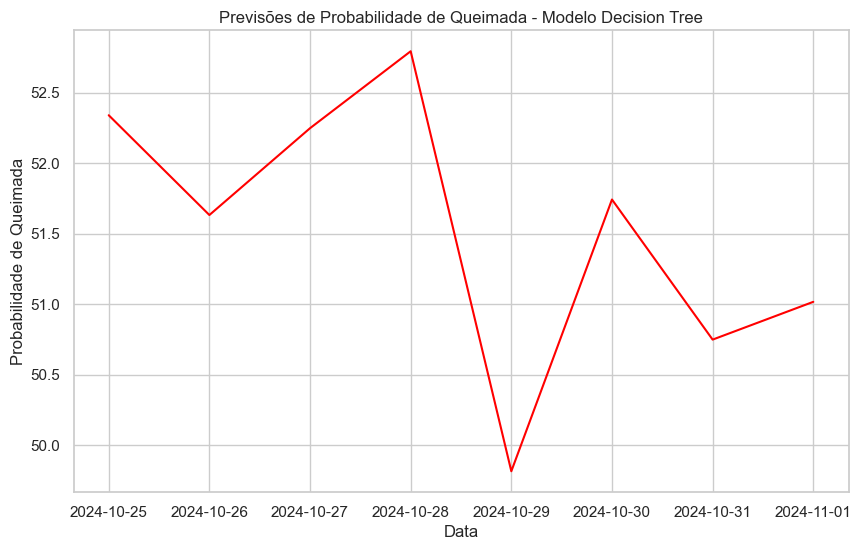

In [129]:
# Garantindo que as datas estão no formato correto e ordenando os dados
resultados_novos['Data'] = pd.to_datetime(resultados_novos['Data'])
resultados_novos = resultados_novos.sort_values(by='Data')

# Configuração do gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=resultados_novos, x='Data', y='probabilidade', color='red', ci=None)  # ci=None remove as margens

# Ajuste dos títulos e eixos
plt.title('Previsões de Probabilidade de Queimada - Modelo Decision Tree')
plt.xlabel('Data')
plt.ylabel('Probabilidade de Queimada')

# Exibir o gráfico
plt.show()